#### Hacemos lo mismo que en el 12.2 pero usando la energía real de los sucesos simulados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ctapipe.io import TableLoader, read_table
import scipy
import seaborn as sns

# RandomForest
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Distribución del clasificador
import scipy.stats as stats

/tmp/ipykernel_5873/2707244459.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### 1. RFC Básico

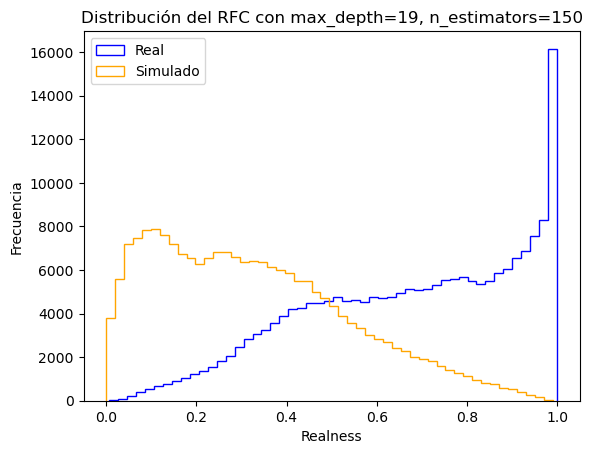

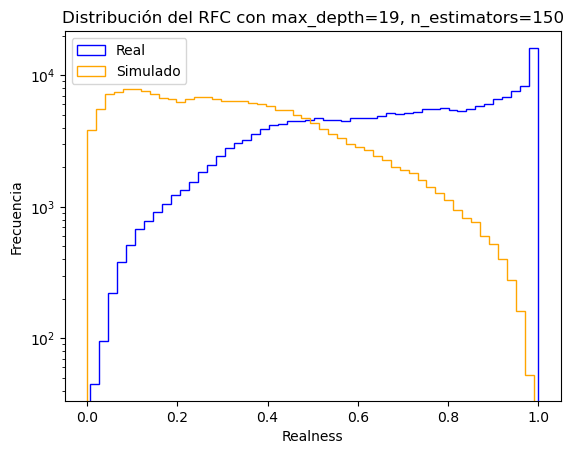

In [3]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)

# Determinamos los parámetros
features = ['hillas_intensity', 'hillas_skewness', 'hillas_kurtosis', 'hillas_length', 'hillas_width', 'timing_slope']
protons_tel_events_f = protons_tel_events[features] 
protons_tel_events_f2 = protons_tel_events2[features] 

# Convertimos a dataframe y eliminamos los NaN values
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
# Juntamos los dos dataframe
df_simu = pd.concat([df_protons, df_protons2], axis=0)

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = ['intensity', 'skewness', 'kurtosis', 'length', 'width', 'time_gradient', 'event_type']
df_realC = tb[features]
# Convertimos a dataframe y eliminamos los NaN values
df_realC = df_realC.dropna()
# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)
# Filtramos nuestro dataframe para únicamente los eventos de tipo 32 y 2 (nos quita los eventos de tipo 0)
df_realC = df_realC[(df_realC['event_type'] >= 2)]
df_realC = df_realC.drop("event_type", axis=1)

# Dataframe de datos reales
df_real = df_realC

# Filtramos los datos reales para que sean de la misma longitud que los simulados
df_real = df_real.head(df_simu.shape[0])

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu, df_real], axis=0)

df_simureal.insert(6,"label", label, True)

X1 = df_simureal.drop("label", axis=1)
y1 = df_simureal["label"]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.25)
rfrs1 = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs1.fit(X_train1, y_train1)

y_pred1 = (rfrs1.predict_proba(X_test1))
realness = y_pred1[:,0]                                                                              # Gammaness predicha
label = y_test1                                                                                       # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

### 2. Filto a intensidad > 200

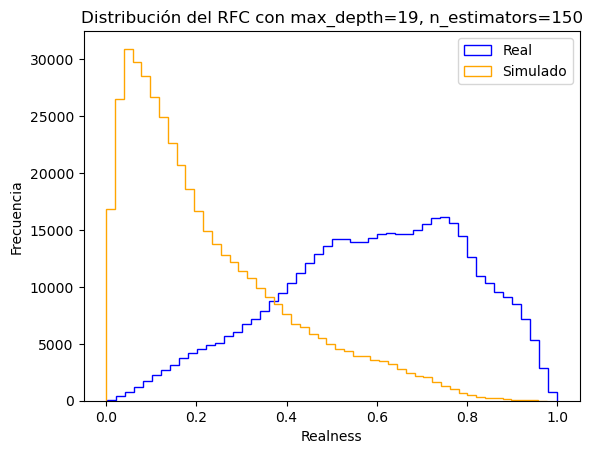

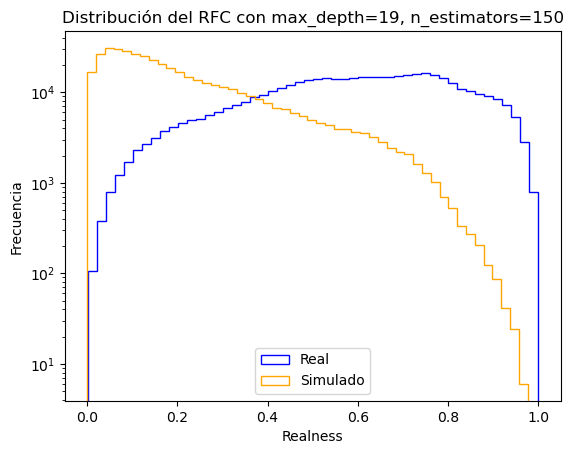

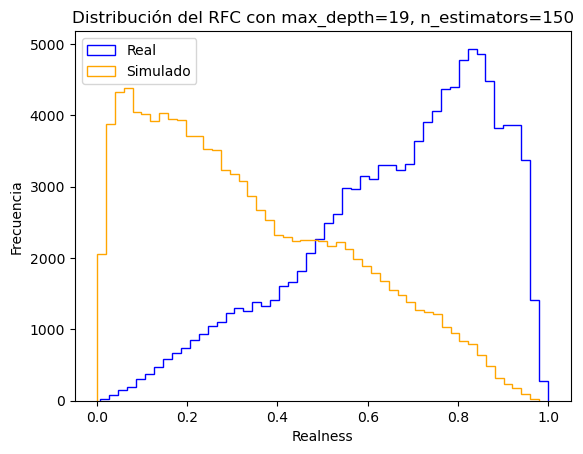

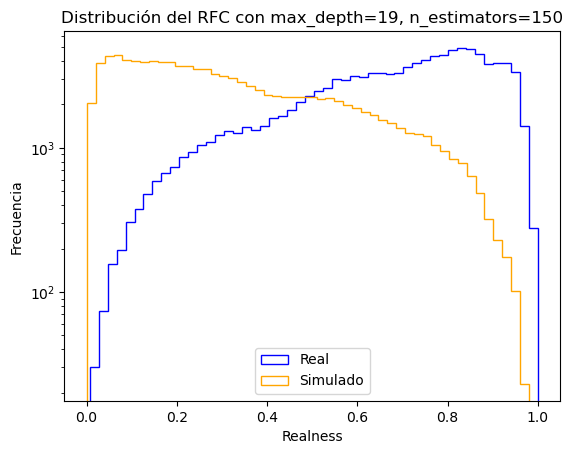

In [5]:
# Convertimos a dataframe y eliminamos los NaN values
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons = df_protons[(df_protons['hillas_intensity']>200)]
df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
df_protons2 = df_protons2[(df_protons2['hillas_intensity']>200)]
# Juntamos los dos dataframe
df_simu = pd.concat([df_protons, df_protons2], axis=0)

# Convertimos a dataframe y eliminamos los NaN values
df_realC = df_realC.dropna()
# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

df_realC = df_realC[(df_realC['hillas_intensity']>200)]
# Dataframe de datos reales
df_real = df_realC
# Filtramos los datos reales para que sean de la misma longitud que los simulados
df_real = df_real.head(df_simu.shape[0])

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu, df_real], axis=0)

df_simureal.insert(6,"label", label, True)

X2 = df_simureal.drop("label", axis=1)
y2 = df_simureal["label"]

y_pred2 = (rfrs1.predict_proba(X2))
realness = y_pred2[:,0]                                                                              # Gammaness predicha
label = y2                                                                                           # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.25)
rfrs2 = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs2.fit(X_train2, y_train2)

y_pred2 = (rfrs2.predict_proba(X_test2))
realness = y_pred2[:,0]                                                                              # Gammaness predicha
label = y_test2                                                                                      # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

### 3. Ajustar energía

/tmp/ipykernel_5873/4267003974.py:33: RuntimeWarning: divide by zero encountered in power
  P.append(true_energy_20[i]**(-2.7) / true_energy_20[i]**(-2.0))
/tmp/ipykernel_5873/4267003974.py:33: RuntimeWarning: invalid value encountered in scalar divide
  P.append(true_energy_20[i]**(-2.7) / true_energy_20[i]**(-2.0))


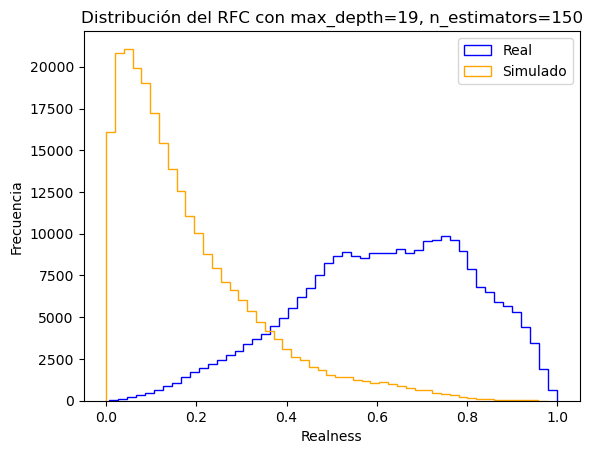

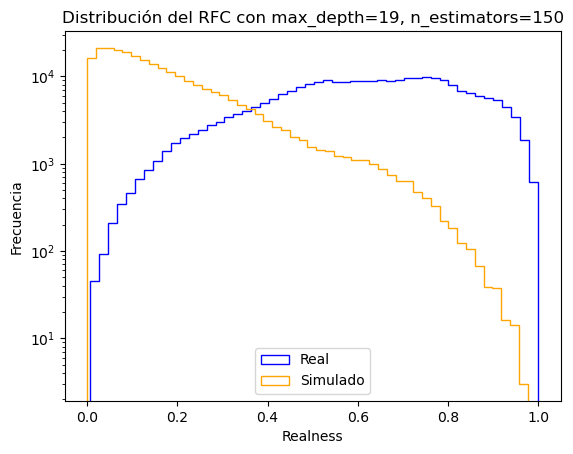

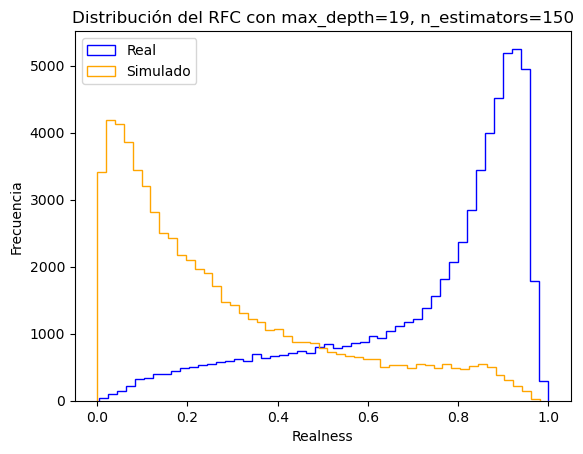

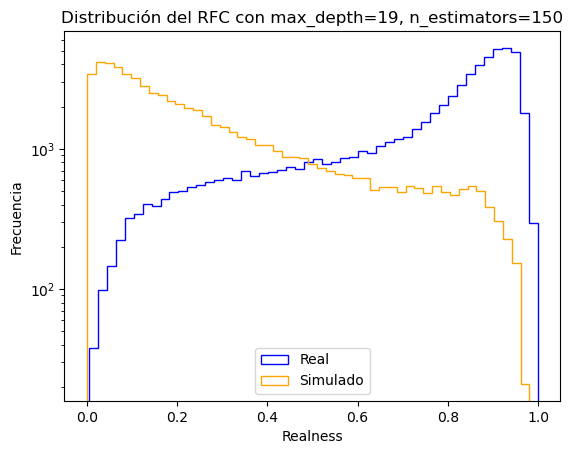

In [9]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)

# Determinamos los parámetros
features = ['hillas_intensity', 'hillas_skewness', 'hillas_kurtosis', 'hillas_length', 'hillas_width', 'timing_slope', 'true_energy']
protons_tel_events_f = protons_tel_events[features] 
protons_tel_events_f2 = protons_tel_events2[features] 

# Convertimos a dataframe y eliminamos los NaN values
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons = df_protons[(df_protons['hillas_intensity']>200)]
df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
df_protons2 = df_protons2[(df_protons2['hillas_intensity']>200)]
# Juntamos los dos dataframe
df_simu = pd.concat([df_protons, df_protons2], axis=0)

# ------- PROCESO DE AJUSTE DE LA ENERGÍA --------------------------------#
# PASO 1
# Añadimos una columna con los valores de la energía normalizados ya que solo podemos trabajar con datos mayores que 1
Emin = np.min(df_simu['true_energy'])
df_simu.loc[:, "true_energy_norm"] = df_simu['true_energy'] > 1
true_energy_20 = df_simu["true_energy_norm"]

# PASO 2
P = []
true_energy_20 = true_energy_20.values
for i in range(len(true_energy_20)):
    P.append(true_energy_20[i]**(-2.7) / true_energy_20[i]**(-2.0))

# PASO 3
def sobrevive(proba, energy):
    # Crear un nuevo array para almacenar los números sobrevivientes
    sobrevivientes = []
    # Iterar sobre los números y las probabilidades
    for i, probabilidad in enumerate(proba):
        # Generar un número aleatorio entre 0 y 1
        aleatorio = np.random.rand()
        # Si el número aleatorio es menor o igual a la probabilidad, el número sobrevive
        if aleatorio <= proba[i]:
            sobrevivientes.append(energy[i])
        else:
            sobrevivientes.append(0)
    return sobrevivientes

true_energy_27 = sobrevive(P, true_energy_20)

# PASO 4
# Filtramos el dataframe de simulados para los valores de true_energy_2.7 distintos a 0
df_simu.loc[:, "true_energy_filter"] = true_energy_27
df_simu = df_simu[df_simu['true_energy_filter'] != 0]
# Sacamos el dataframe de datos simulados finales
df_simu = df_simu.drop("true_energy", axis=1)
df_simu = df_simu.drop("true_energy_filter", axis=1)
df_simu = df_simu.drop("true_energy_norm", axis=1)
df_simu = df_simu.dropna()
# ------------------------------------------------------------------------------#

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = ['intensity', 'skewness', 'kurtosis', 'length', 'width', 'time_gradient', 'event_type']
df_realC = tb[features]
# Convertimos a dataframe y eliminamos los NaN values
df_realC = df_realC.dropna()
# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)
# Filtramos nuestro dataframe para únicamente los eventos de tipo 32 y 2 (nos quita los eventos de tipo 0)
df_realC = df_realC[(df_realC['event_type'] >= 2)]
df_realC = df_realC.drop("event_type", axis=1)

# Dataframe de datos reales
df_real = df_realC[(df_realC['hillas_intensity']>200)]

# Filtramos los datos reales para que sean de la misma longitud que los simulados
df_real = df_real.head(df_simu.shape[0])

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu, df_real], axis=0)

df_simureal.insert(6,"label", label, True)

X3 = df_simureal.drop("label", axis=1)
y3 = df_simureal["label"]

y_pred3 = (rfrs1.predict_proba(X3))
realness = y_pred3[:,0]                                                                              # Gammaness predicha
label = y3                                                                                           # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.25)
rfrs3 = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs3.fit(X_train3, y_train3)

y_pred3 = (rfrs3.predict_proba(X_test3))
realness = y_pred3[:,0]                                                                              # Gammaness predicha
label = y_test3                                                                                      # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

### 4. Filtro de gammaness

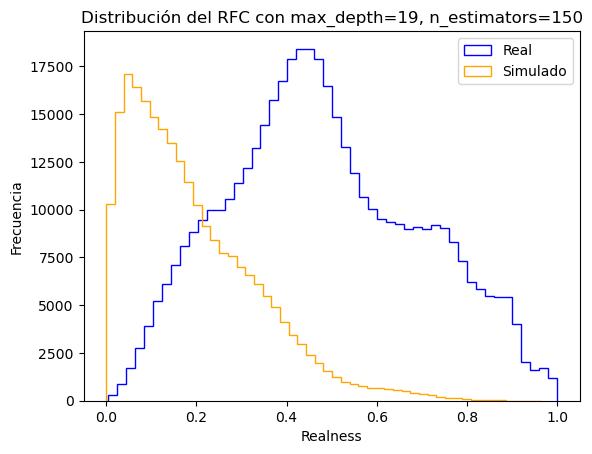

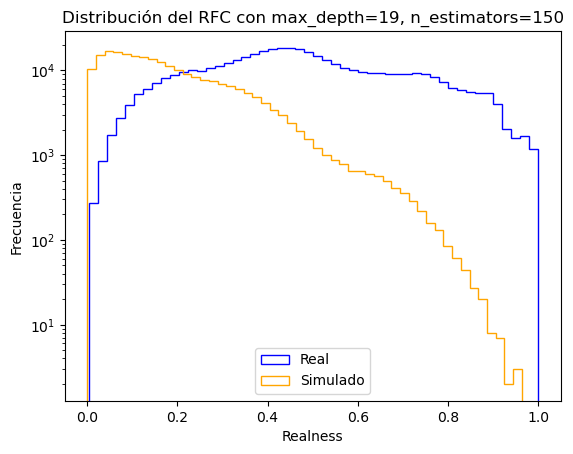

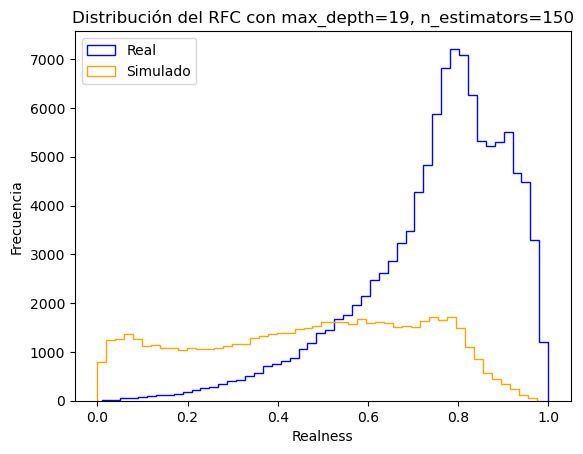

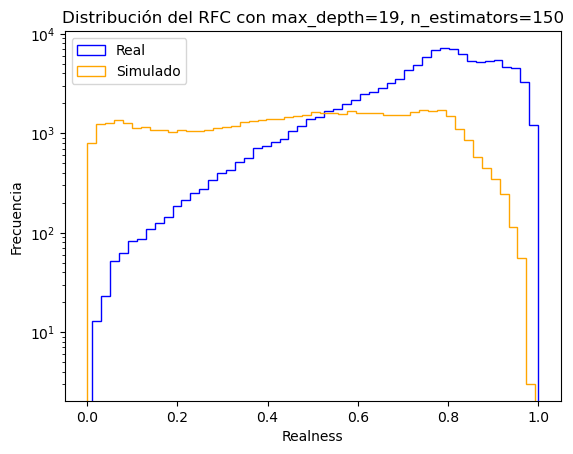

In [10]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=1452118)

with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events2 = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=33922
)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]
protons_tel_events_f2 = protons_tel_events2[features] 
gamma_tel_events_f2=gamma_tel_events2[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons = df_protons[(df_protons['hillas_intensity']>200)]

df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
df_protons2 = df_protons2[(df_protons2['hillas_intensity']>200)]

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma = df_gamma[(df_gamma['hillas_intensity']>200)]

df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()
df_gamma2 = df_gamma2[(df_gamma2['hillas_intensity']>200)]

# Juntamos los cuatro dataframe
df_protongamma = pd.concat([df_protons, df_protons2, df_gamma, df_gamma2], axis=0)

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_protons)):
    label.append(1)                                                                   # Nombramos los protones como 1
for i2 in range(len(df_protons2)):
    label.append(1)
for j in range(len(df_gamma)):
    label.append(0)                                                                   # Nombramos los gamma como 0
for j2 in range(len(df_gamma2)):
    label.append(0)
    
df_protongamma.insert(6,"label", label, True)

Xc = df_protongamma.drop("label", axis=1)                                              # Determina los parámetros 
yc = df_protongamma["label"]

X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=0.25)
rfgammaness = RandomForestClassifier(max_depth=19, n_estimators=150)
rfgammaness.fit(X_train, y_train)

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            #'gammaness'
            ]

df_realC = tb[features]
df_realC = df_realC.dropna()
df_realC = df_realC[(df_realC['intensity']>200)]

# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

# Filtramos nuestro dataframe para únicamente los eventos de tipo 32 y 2 (nos quita los eventos de tipo 1)
df_realC = df_realC[(df_realC['event_type'] >= 2)]

# Eliminamos la columna de event_type del dataframe ya filtrado y ya tendríamos nuestros datos para el modelo
df_real = df_realC.drop("event_type", axis=1)

# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)

# Determinamos los parámetros
features = ['hillas_intensity', 'hillas_skewness', 'hillas_kurtosis', 'hillas_length', 'hillas_width', 'timing_slope']
protons_tel_events_f = protons_tel_events[features] 
protons_tel_events_f2 = protons_tel_events2[features] 

# Convertimos a dataframe y eliminamos los NaN values
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons = df_protons[(df_protons['hillas_intensity']>200)]
df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
df_protons2 = df_protons2[(df_protons2['hillas_intensity']>200)]
# Juntamos los dos dataframe
df_simu = pd.concat([df_protons, df_protons2], axis=0)

y_pred = (rfgammaness.predict_proba(df_simu))
proba = y_pred[:,0]  
y_pred_real = (rfgammaness.predict_proba(df_real))
proba_real = y_pred_real[:,0] 

# Unimos los dataframes a su gammaness correspondiente
df_simu.loc[:, "gammaness"] = proba
df_real.loc[:, "gammaness"] = proba_real

# Eliminamos los eventos de alta gammaness
df_simu2 = df_simu[(df_simu['gammaness']<0.2)]
df_real2 = df_real[(df_real['gammaness']<0.2)]

df_simu2 = df_simu2.drop("gammaness", axis=1)
df_real2 = df_real2.drop("gammaness", axis=1)

# Filtramos los datos reales para que sean de la misma longitud que los simulados
df_real2 = df_real2.head(df_simu.shape[0])
df_simu2 = df_simu2.head(df_real.shape[0])

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu2)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real2)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu2, df_real2], axis=0)

df_simureal.insert(6,"label", label, True)

X4 = df_simureal.drop("label", axis=1)
y4 = df_simureal["label"]

y_pred4 = (rfrs1.predict_proba(X4))
realness = y_pred4[:,0]                                                                              # Gammaness predicha
label = y4                                                                                           # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.25)
rfrs4 = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs4.fit(X_train4, y_train4)

y_pred4 = (rfrs4.predict_proba(X_test4))
realness = y_pred4[:,0]                                                                              # Gammaness predicha
label = y_test4                                                                                      # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

### 5. Ajuste de energía 2

       hillas_intensity  hillas_skewness  hillas_kurtosis  hillas_length  \
3            577.332421         0.188235         1.695745       0.308969   
5            552.692280        -0.348821         2.403907       0.184209   
12           380.201642        -0.030697         1.641901       0.276596   
13           433.460289        -0.703524         2.374887       0.138545   
17           386.226773        -0.037960         2.168370       0.119900   
...                 ...              ...              ...            ...   
51415        273.299998         0.731815         2.918332       0.096856   
51417        914.260375        -1.029094         3.479541       0.543672   
51418        811.377876        -0.342327         2.062407       0.450407   
51419        558.215005        -0.396085         1.971028       0.529878   
51428        206.739210         0.155600         2.444209       0.109396   

       hillas_width  timing_slope  true_energy  true_energy_norm  
3          0.167774 

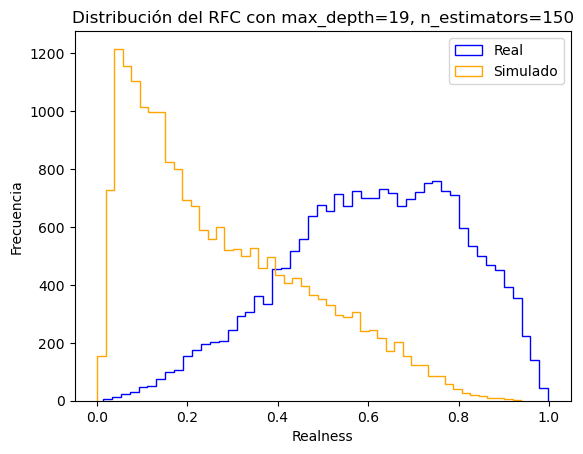

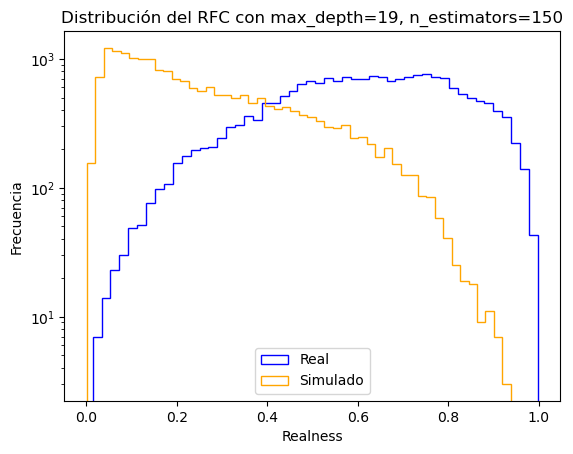

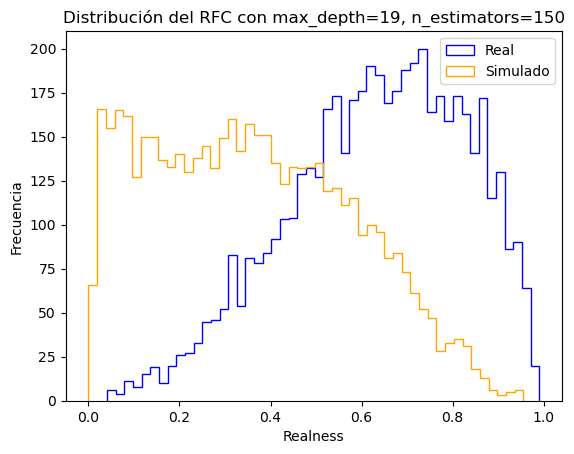

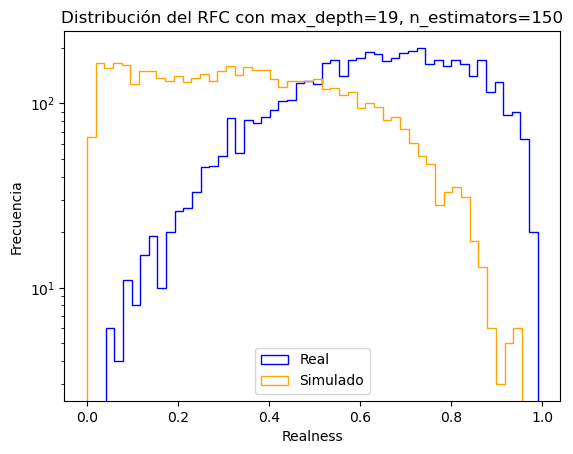

In [15]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)

# Determinamos los parámetros
features = ['hillas_intensity', 'hillas_skewness', 'hillas_kurtosis', 'hillas_length', 'hillas_width', 'timing_slope', 'true_energy']
protons_tel_events_f = protons_tel_events[features] 
protons_tel_events_f2 = protons_tel_events2[features] 

# Convertimos a dataframe y eliminamos los NaN values
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons = df_protons[(df_protons['hillas_intensity']>200)]
df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
df_protons2 = df_protons2[(df_protons2['hillas_intensity']>200)]
# Juntamos los dos dataframe
df_simu = pd.concat([df_protons, df_protons2], axis=0)

# ------- PROCESO DE AJUSTE DE LA ENERGÍA --------------------------------#
# PASO 1
# Añadimos una columna con los valores de la energía normalizados ya que solo podemos trabajar con datos mayores que 1
Emin = np.min(df_simu['true_energy'])
df_simu.loc[:, "true_energy_norm"] = df_simu['true_energy'].values/Emin
true_energy_20 = df_simu["true_energy_norm"]
# Mostramos el nuevo dataframe para comprobar los ajustes
print(df_simu)

# PASO 2
P = []
true_energy_20 = true_energy_20.values
for i in range(len(true_energy_20)):
    P.append(true_energy_20[i]**(-2.7) / true_energy_20[i]**(-2.0))

# PASO 3
def sobrevive(proba, energy):
    # Crear un nuevo array para almacenar los números sobrevivientes
    sobrevivientes = []
    # Iterar sobre los números y las probabilidades
    for i, probabilidad in enumerate(proba):
        # Generar un número aleatorio entre 0 y 1
        aleatorio = np.random.rand()
        # Si el número aleatorio es menor o igual a la probabilidad, el número sobrevive
        if aleatorio <= proba[i]:
            sobrevivientes.append(energy[i])
        else:
            sobrevivientes.append(0)
    return sobrevivientes

true_energy_27 = sobrevive(P, true_energy_20)

# PASO 4
# Filtramos el dataframe de simulados para los valores de true_energy_2.7 distintos a 0
df_simu.loc[:, "true_energy_filter"] = true_energy_27
df_simu = df_simu[df_simu['true_energy_filter'] != 0]
# Sacamos el dataframe de datos simulados finales
df_simu = df_simu.drop("true_energy", axis=1)
df_simu = df_simu.drop("true_energy_filter", axis=1)
df_simu = df_simu.drop("true_energy_norm", axis=1)
df_simu = df_simu.dropna()
# ------------------------------------------------------------------------------#

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = ['intensity', 'skewness', 'kurtosis', 'length', 'width', 'time_gradient', 'event_type']
df_realC = tb[features]
# Convertimos a dataframe y eliminamos los NaN values
df_realC = df_realC.dropna()
# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)
# Filtramos nuestro dataframe para únicamente los eventos de tipo 32 y 2 (nos quita los eventos de tipo 0)
df_realC = df_realC[(df_realC['event_type'] >= 2)]
df_realC = df_realC.drop("event_type", axis=1)

# Dataframe de datos reales
df_real = df_realC[(df_realC['hillas_intensity']>200)]

# Filtramos los datos reales para que sean de la misma longitud que los simulados
df_real = df_real.head(df_simu.shape[0])

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu, df_real], axis=0)

df_simureal.insert(6,"label", label, True)

X5 = df_simureal.drop("label", axis=1)
y5 = df_simureal["label"]

y_pred5 = (rfrs1.predict_proba(X5))
realness = y_pred5[:,0]                                                                              # Gammaness predicha
label = y5                                                                                           # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.25)
rfrs5 = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs5.fit(X_train5, y_train5)

y_pred5 = (rfrs5.predict_proba(X_test5))
realness = y_pred5[:,0]                                                                              # Gammaness predicha
label = y_test5                                                                                      # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

### 6. Filtro de gammaness 2

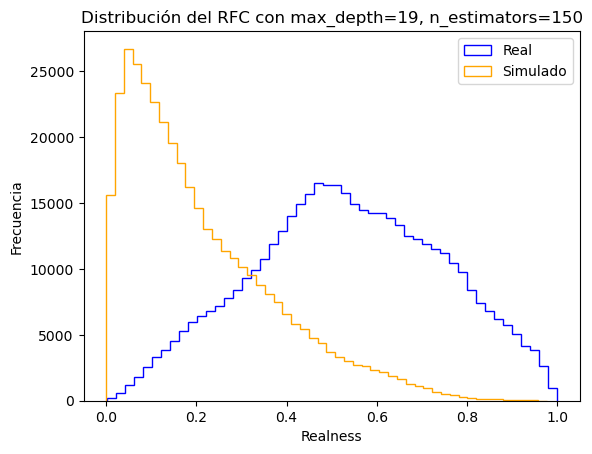

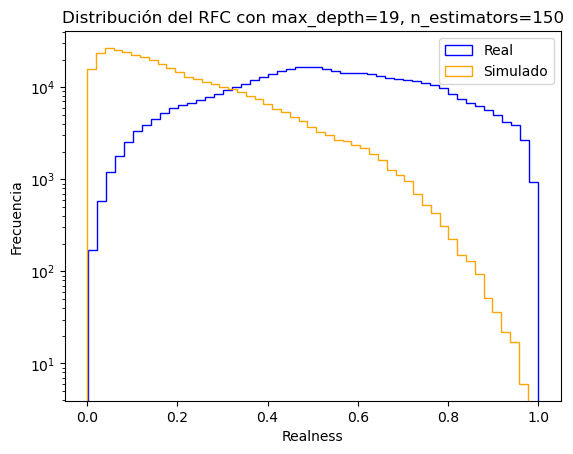

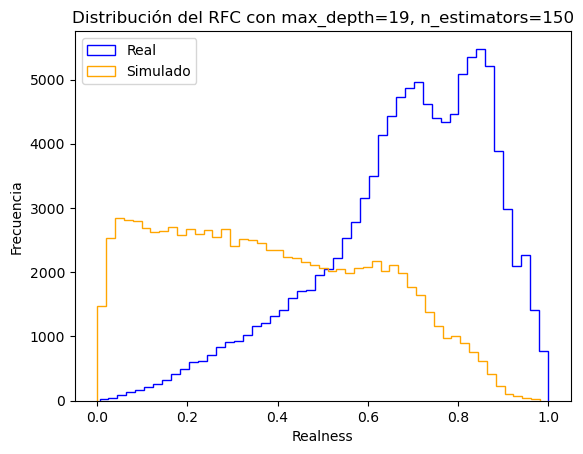

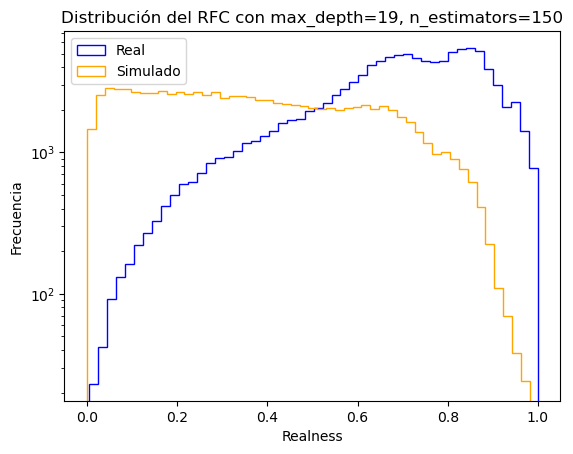

In [22]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=1452118)

with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events2 = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=33922
)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]
protons_tel_events_f2 = protons_tel_events2[features] 
gamma_tel_events_f2=gamma_tel_events2[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons = df_protons[(df_protons['hillas_intensity']>200)]

df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
df_protons2 = df_protons2[(df_protons2['hillas_intensity']>200)]

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma = df_gamma[(df_gamma['hillas_intensity']>200)]

df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()
df_gamma2 = df_gamma2[(df_gamma2['hillas_intensity']>200)]

# Juntamos los cuatro dataframe
df_protongamma = pd.concat([df_protons, df_protons2, df_gamma, df_gamma2], axis=0)

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_protons)):
    label.append(1)                                                                   # Nombramos los protones como 1
for i2 in range(len(df_protons2)):
    label.append(1)
for j in range(len(df_gamma)):
    label.append(0)                                                                   # Nombramos los gamma como 0
for j2 in range(len(df_gamma2)):
    label.append(0)
    
df_protongamma.insert(6,"label", label, True)

Xc = df_protongamma.drop("label", axis=1)                                              # Determina los parámetros 
yc = df_protongamma["label"]

X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=0.25)
rfgammaness = RandomForestClassifier(max_depth=19, n_estimators=150)
rfgammaness.fit(X_train, y_train)

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            #'gammaness'
            ]

df_realC = tb[features]
df_realC = df_realC.dropna()
df_realC = df_realC[(df_realC['intensity']>200)]

# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

# Filtramos nuestro dataframe para únicamente los eventos de tipo 32 y 2 (nos quita los eventos de tipo 1)
df_realC = df_realC[(df_realC['event_type'] >= 2)]

# Eliminamos la columna de event_type del dataframe ya filtrado y ya tendríamos nuestros datos para el modelo
df_real = df_realC.drop("event_type", axis=1)

# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)

# Determinamos los parámetros
features = ['hillas_intensity', 'hillas_skewness', 'hillas_kurtosis', 'hillas_length', 'hillas_width', 'timing_slope']
protons_tel_events_f = protons_tel_events[features] 
protons_tel_events_f2 = protons_tel_events2[features] 

# Convertimos a dataframe y eliminamos los NaN values
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons = df_protons[(df_protons['hillas_intensity']>200)]
df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
df_protons2 = df_protons2[(df_protons2['hillas_intensity']>200)]
# Juntamos los dos dataframe
df_simu = pd.concat([df_protons, df_protons2], axis=0)

y_pred = (rfgammaness.predict_proba(df_simu))
proba = y_pred[:,0]  
y_pred_real = (rfgammaness.predict_proba(df_real))
proba_real = y_pred_real[:,0] 

# Unimos los dataframes a su gammaness correspondiente
df_simu.loc[:, "gammaness"] = proba
df_real.loc[:, "gammaness"] = proba_real

# Eliminamos los eventos de alta gammaness
df_simu2 = df_simu[(df_simu['gammaness']<0.5)]
df_real2 = df_real[(df_real['gammaness']<0.5)]

df_simu2 = df_simu2.drop("gammaness", axis=1)
df_real2 = df_real2.drop("gammaness", axis=1)

# Filtramos los datos reales para que sean de la misma longitud que los simulados
df_real2 = df_real2.head(df_simu.shape[0])
df_simu2 = df_simu2.head(df_real.shape[0])

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu2)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real2)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu2, df_real2], axis=0)

df_simureal.insert(6,"label", label, True)

X6 = df_simureal.drop("label", axis=1)
y6 = df_simureal["label"]

y_pred6 = (rfrs1.predict_proba(X6))
realness = y_pred6[:,0]                                                                              # Gammaness predicha
label = y6                                                                                           # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6, test_size=0.25)
rfrs6 = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs6.fit(X_train6, y_train6)

y_pred6 = (rfrs6.predict_proba(X_test6))
realness = y_pred6[:,0]                                                                              # Gammaness predicha
label = y_test6                                                                                      # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

### Filtro gammaness 3

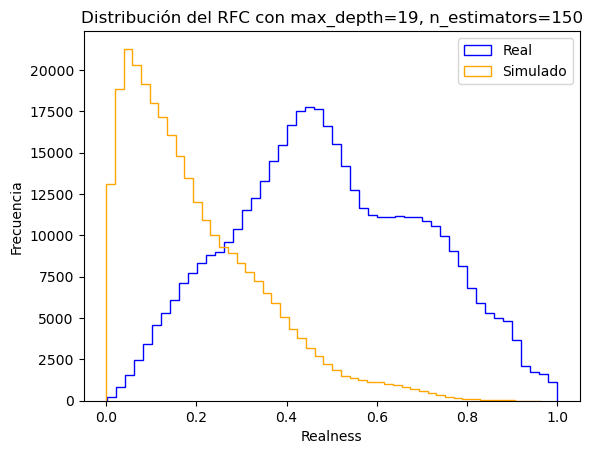

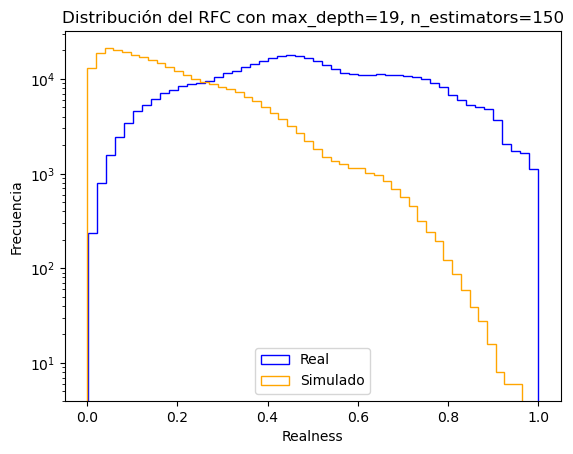

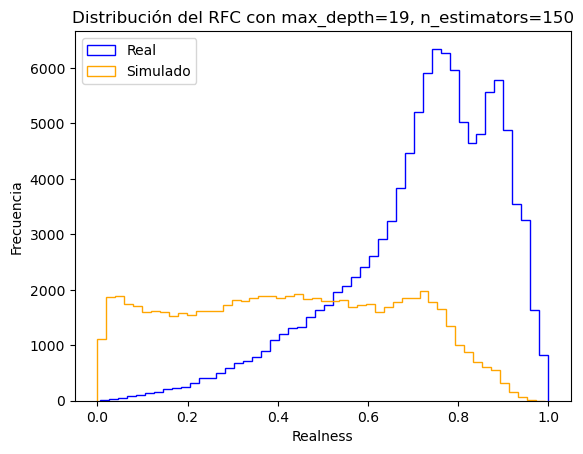

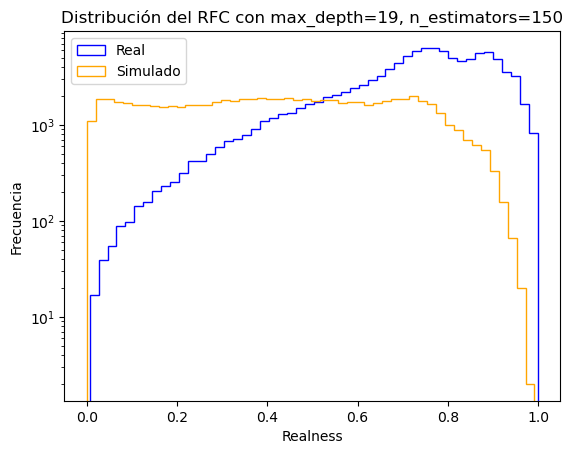

In [23]:
# Eliminamos los eventos de alta gammaness
df_simu2 = df_simu[(df_simu['gammaness']<0.3)]
df_real2 = df_real[(df_real['gammaness']<0.3)]

df_simu2 = df_simu2.drop("gammaness", axis=1)
df_real2 = df_real2.drop("gammaness", axis=1)

# Filtramos los datos reales para que sean de la misma longitud que los simulados
df_real2 = df_real2.head(df_simu.shape[0])
df_simu2 = df_simu2.head(df_real.shape[0])

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu2)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real2)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu2, df_real2], axis=0)

df_simureal.insert(6,"label", label, True)

X7 = df_simureal.drop("label", axis=1)
y7 = df_simureal["label"]

y_pred7 = (rfrs1.predict_proba(X7))
realness = y_pred7[:,0]                                                                              # Gammaness predicha
label = y7                                                                                           # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

X_train7, X_test7, y_train7, y_test7 = train_test_split(X7, y7, test_size=0.25)
rfrs7 = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs7.fit(X_train7, y_train7)

y_pred7 = (rfrs7.predict_proba(X_test7))
realness = y_pred7[:,0]                                                                              # Gammaness predicha
label = y_test7                                                                                      # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

### Filtro gammaness 4

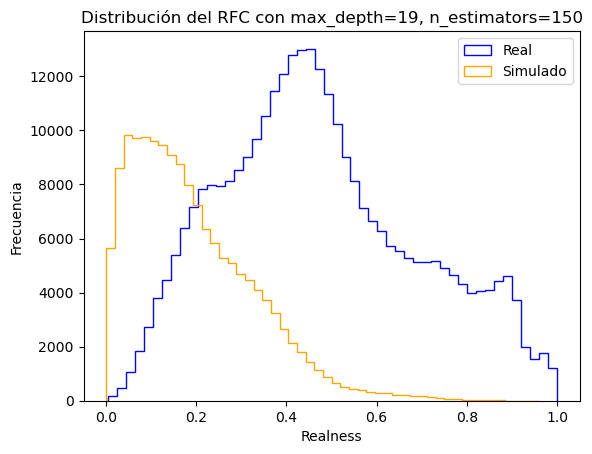

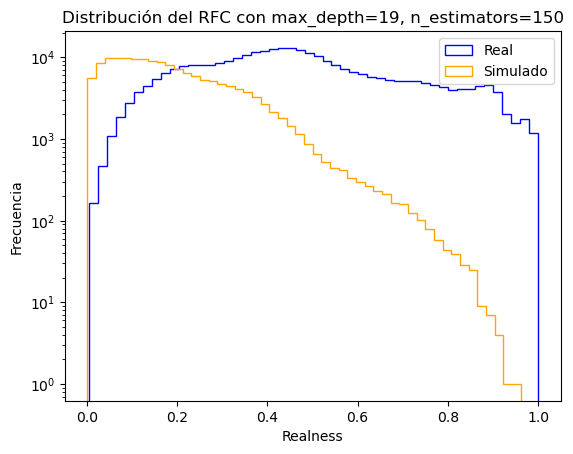

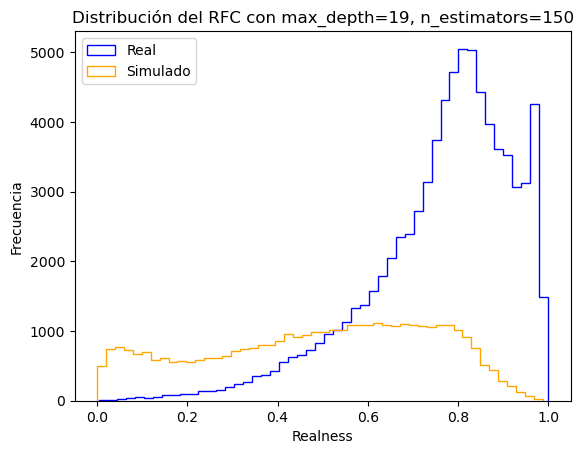

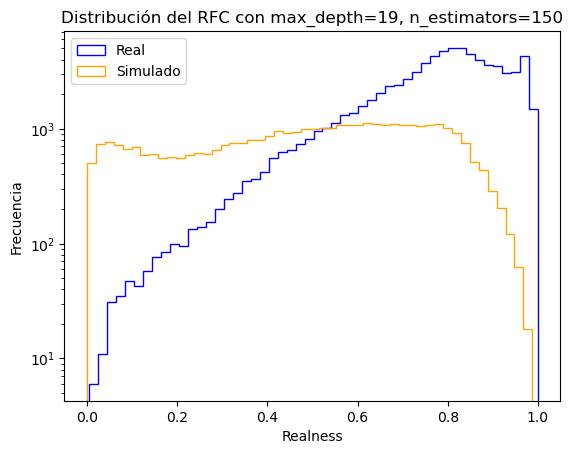

In [27]:
# Eliminamos los eventos de alta gammaness
df_simu2 = df_simu[(df_simu['gammaness']<0.1)]
df_real2 = df_real[(df_real['gammaness']<0.1)]

df_simu2 = df_simu2.drop("gammaness", axis=1)
df_real2 = df_real2.drop("gammaness", axis=1)

# Filtramos los datos reales para que sean de la misma longitud que los simulados
df_real2 = df_real2.head(df_simu.shape[0])
df_simu2 = df_simu2.head(df_real.shape[0])

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu2)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real2)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu2, df_real2], axis=0)

df_simureal.insert(6,"label", label, True)

X8 = df_simureal.drop("label", axis=1)
y8 = df_simureal["label"]

y_pred8 = (rfrs1.predict_proba(X8))
realness = y_pred8[:,0]                                                                              # Gammaness predicha
label = y8                                                                                           # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

X_train8, X_test8, y_train8, y_test8 = train_test_split(X8, y8, test_size=0.25)
rfrs8 = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs8.fit(X_train8, y_train8)

y_pred8 = (rfrs8.predict_proba(X_test8))
realness = y_pred8[:,0]                                                                              # Gammaness predicha
label = y_test8                                                                                      # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
realness_real = realness[label == 0]
realness_simu = realness[label == 1]

plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
plt.hist(realness_real, bins=50, histtype=u'step', color = 'blue', label='Real')  
plt.hist(realness_simu, bins=50, histtype=u'step', color = 'orange', label='Simulado')  

plt.title("Distribución del RFC con max_depth=19, n_estimators=150")
plt.xlabel("Realness")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

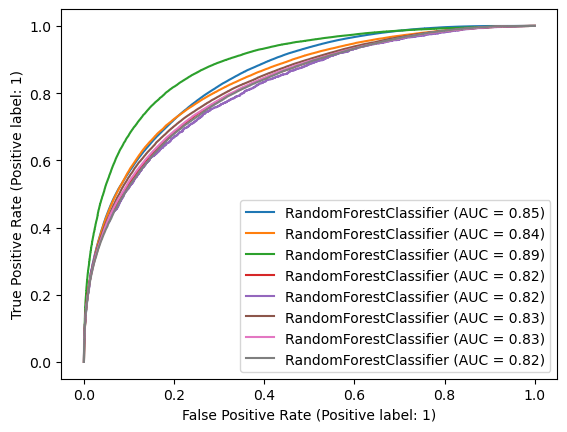

In [28]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
rf_ROC_disp1 = RocCurveDisplay.from_estimator(rfrs1, X_test1, y_test1, ax=ax, label = 'RFC Básico')
rf_ROC_disp3 = RocCurveDisplay.from_estimator(rfrs2, X_test2, y_test2, ax=ax, label = 'RFC int > 200')
rf_ROC_disp5 = RocCurveDisplay.from_estimator(rfrs3, X_test3, y_test3, ax=ax, label = 'RFC E^(2.7) > 1')
rf_ROC_disp9 = RocCurveDisplay.from_estimator(rfrs5, X_test5, y_test5, ax=ax, label = 'RFC E^(2.7) todas')
rf_ROC_disp11 = RocCurveDisplay.from_estimator(rfrs6, X_test6, y_test6, ax=ax, label = 'RFC g < 0.5')
rf_ROC_disp13 = RocCurveDisplay.from_estimator(rfrs7, X_test7, y_test7, ax=ax, label = 'RFC g < 0.3')
rf_ROC_disp7 = RocCurveDisplay.from_estimator(rfrs4, X_test4, y_test4, ax=ax, label = 'RFC g < 0.2')
rf_ROC_disp15 = RocCurveDisplay.from_estimator(rfrs8, X_test8, y_test8, ax=ax, label = 'RFC g < 0.1')
plt.show()

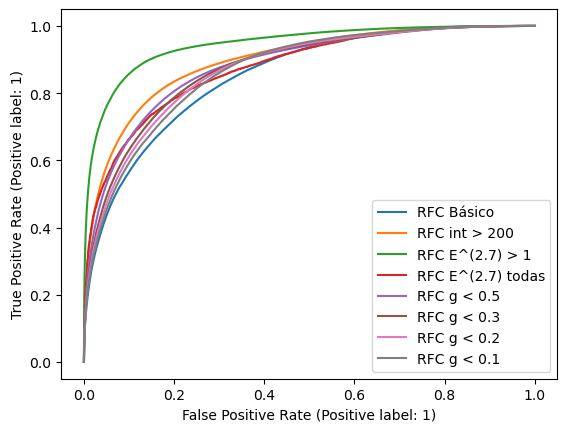

In [31]:
ax = plt.gca()
rf_ROC_disp1 = RocCurveDisplay.from_estimator(rfrs1, X_test1, y_test1, ax=ax, label = 'RFC Básico')
rf_ROC_disp2 = RocCurveDisplay.from_estimator(rfrs1, X2, y2, ax=ax, label = 'RFC int > 200')
rf_ROC_disp4 = RocCurveDisplay.from_estimator(rfrs1, X3, y3, ax=ax, label = 'RFC E^(2.7) > 1')
rf_ROC_disp8 = RocCurveDisplay.from_estimator(rfrs1, X5, y5, ax=ax, label = 'RFC E^(2.7) todas')
rf_ROC_disp10 = RocCurveDisplay.from_estimator(rfrs1, X6, y6, ax=ax, label = 'RFC g < 0.5')
rf_ROC_disp12 = RocCurveDisplay.from_estimator(rfrs1, X7, y7, ax=ax, label = 'RFC g < 0.3')
rf_ROC_disp6 = RocCurveDisplay.from_estimator(rfrs1, X4, y4, ax=ax, label = 'RFC g < 0.2')
rf_ROC_disp14 = RocCurveDisplay.from_estimator(rfrs1, X8, y8, ax=ax, label = 'RFC g < 0.1')
plt.show()

In [30]:
print(len(X1))
print(len(y1))
print()
print(len(X2))
print(len(y2))
print()
print(len(X3))
print(len(y3))
print()
print(len(X5))
print(len(y5))
print()
print(len(X6))
print(len(y6))
print()
print(len(X7))
print(len(y7))
print()
print(len(X4))
print(len(y4))
print()
print(len(X8))
print(len(y8))

1621178
1621178

892832
892832

517032
517032

685769
685769

41180
41180

821939
821939

740654
740654

466555
466555


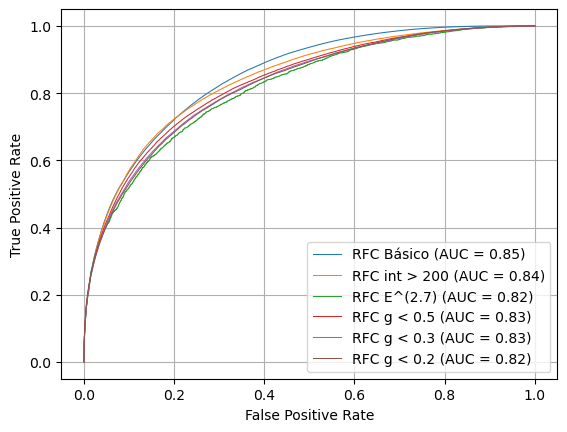

0.8524213797356492
0.8425263130867137
0.817437521922778
0.8318941750496353
0.8256973897070223
0.8245355424575793


In [58]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test1, y_pred1[:,1])
roc_auc1 = metrics.auc(fpr1, tpr1)
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test2, y_pred2[:,1])
roc_auc2 = metrics.auc(fpr2, tpr2)
fpr3, tpr3, thresholds3 = metrics.roc_curve(y_test3, y_pred3[:,1])
roc_auc3 = metrics.auc(fpr3, tpr3)
fpr4, tpr4, thresholds4 = metrics.roc_curve(y_test4, y_pred4[:,1])
roc_auc4 = metrics.auc(fpr4, tpr4)
fpr5, tpr5, thresholds5 = metrics.roc_curve(y_test5, y_pred5[:,1])
roc_auc5 = metrics.auc(fpr5, tpr5)
fpr6, tpr6, thresholds6 = metrics.roc_curve(y_test6, y_pred6[:,1])
roc_auc6 = metrics.auc(fpr6, tpr6)
fpr7, tpr7, thresholds7 = metrics.roc_curve(y_test7, y_pred7[:,1])
roc_auc7 = metrics.auc(fpr7, tpr7)
fpr8, tpr8, thresholds8 = metrics.roc_curve(y_test8, y_pred8[:,1])
roc_auc8 = metrics.auc(fpr8, tpr8)


ax = plt.gca()
metrics.RocCurveDisplay(fpr=fpr1, tpr=tpr1, roc_auc=roc_auc1, estimator_name='RFC Básico').plot(ax=ax, linewidth = 0.75)
metrics.RocCurveDisplay(fpr=fpr2, tpr=tpr2, roc_auc=roc_auc2, estimator_name='RFC int > 200').plot(ax=ax, linewidth = 0.75)
# metrics.RocCurveDisplay(fpr=fpr3, tpr=tpr3, roc_auc=roc_auc3, estimator_name='RFC E^(2.7) > 1').plot(ax=ax, linewidth = 0.75)
metrics.RocCurveDisplay(fpr=fpr5, tpr=tpr5, roc_auc=roc_auc5, estimator_name='RFC E^(2.7)').plot(ax=ax, linewidth = 0.75)
metrics.RocCurveDisplay(fpr=fpr6, tpr=tpr6, roc_auc=roc_auc6, estimator_name='RFC g < 0.5').plot(ax=ax, linewidth = 0.75)
metrics.RocCurveDisplay(fpr=fpr7, tpr=tpr7, roc_auc=roc_auc7, estimator_name='RFC g < 0.3').plot(ax=ax, linewidth = 0.75)
metrics.RocCurveDisplay(fpr=fpr4, tpr=tpr4, roc_auc=roc_auc4, estimator_name='RFC g < 0.2').plot(ax=ax, linewidth = 0.75)
# metrics.RocCurveDisplay(fpr=fpr8, tpr=tpr8, roc_auc=roc_auc8, estimator_name='RFC g < 0.1').plot(ax=ax, linewidth = 0.75)
plt.grid()
plt.savefig('ROC_total.png')
plt.show()


print(roc_auc1)
print(roc_auc2)
# print(roc_auc3)
print(roc_auc5)
print(roc_auc6)
print(roc_auc7)
print(roc_auc4)
# print(roc_auc8)

In [50]:
print(len(X1))
print(len(y1))
print()
print(len(X2))
print(len(y2))
print()
print(len(X5))
print(len(y5))
print()
print(len(X6))
print(len(y6))
print()
print(len(X7))
print(len(y7))
print()
print(len(X4))
print(len(y4))

1621178
1621178

892832
892832

41180
41180

821939
821939

740654
740654

685769
685769
